In [2]:
# Importing necessary libraries
import os
from datetime import datetime
import logging
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Setting up logging and directories
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
logs_dir = f"logs/{timestamp}"
graphs_dir = f"graphs/{timestamp}"

# Create directories if they don't exist
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(graphs_dir, exist_ok=True)

# Setup logger to write to a file in the logs directory
logging.basicConfig(level=logging.INFO, filename=f"{logs_dir}/data_processing.log")
logger = logging.getLogger(__name__)

logger.info("Libraries imported and directories set up.")


In [3]:
# Load the dataset
train_path = "C:/Users/paulo/OneDrive/Documents/Binary-Classification-of-Insurance-Cross-Selling/train.csv"
test_path = "C:/Users/paulo/OneDrive/Documents/Binary-Classification-of-Insurance-Cross-Selling/test.csv"

logger.info("Loading datasets...")
train_df = pd.read_csv(train_path, index_col='id')
test_df = pd.read_csv(test_path, index_col='id')
logger.info("Datasets loaded successfully.")
logger.info(f"Train dataset shape: {train_df.shape}")
logger.info(f"Test dataset shape: {test_df.shape}")


In [4]:
# Basic information
train_info = train_df.info()
test_info = test_df.info()

# Checking for missing values
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

# Displaying the first few rows
train_head = train_df.head()
test_head = test_df.head()

# Logging the information
logger.info(f"Train dataset info: {train_info}")
logger.info(f"Test dataset info: {test_info}")
logger.info(f"Missing values in train dataset:\n{missing_values_train}")
logger.info(f"Missing values in test dataset:\n{missing_values_test}")
logger.info(f"First few rows of train dataset:\n{train_head}")
logger.info(f"First few rows of test dataset:\n{test_head}")


<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB
<class 'pandas.core.frame.DataFrame'>
Index: 7669866 entries, 11504798 to 19174663
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle

In [5]:
# Descriptive statistics for numerical columns
train_describe = train_df.describe()
test_describe = test_df.describe()

# Save descriptive statistics to files
train_describe.to_csv(f"{logs_dir}/train_descriptive_statistics.csv")
test_describe.to_csv(f"{logs_dir}/test_descriptive_statistics.csv")

# Logging descriptive statistics
logger.info(f"Train dataset descriptive statistics:\n{train_describe}")
logger.info(f"Test dataset descriptive statistics:\n{test_describe}")


In [6]:
# Distribution of categorical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
train_categorical_distribution = {col: train_df[col].value_counts() for col in categorical_columns}
test_categorical_distribution = {col: test_df[col].value_counts() for col in categorical_columns}

# Logging categorical distributions
for col, dist in train_categorical_distribution.items():
    logger.info(f"Train dataset - {col} distribution:\n{dist}")

for col, dist in test_categorical_distribution.items():
    logger.info(f"Test dataset - {col} distribution:\n{dist}")

# Save distributions to files
for col, dist in train_categorical_distribution.items():
    dist.to_csv(f"{logs_dir}/train_{col}_distribution.csv")

for col, dist in test_categorical_distribution.items():
    dist.to_csv(f"{logs_dir}/test_{col}_distribution.csv")


In [7]:
# Check for duplicate rows
duplicate_rows_train = train_df.duplicated().sum()
duplicate_rows_test = test_df.duplicated().sum()

# Logging duplicate rows
logger.info(f"Duplicate rows in train dataset: {duplicate_rows_train}")
logger.info(f"Duplicate rows in test dataset: {duplicate_rows_test}")

# Identifying outliers in numerical columns (using Z-score)
z_scores_train = np.abs(stats.zscore(train_df.select_dtypes(include=[np.number])))
outliers_train = np.where(z_scores_train > 3, True, False).sum()

z_scores_test = np.abs(stats.zscore(test_df.select_dtypes(include=[np.number])))
outliers_test = np.where(z_scores_test > 3, True, False).sum()

# Logging outliers
logger.info(f"Outliers in train dataset: {outliers_train}")
logger.info(f"Outliers in test dataset: {outliers_test}")


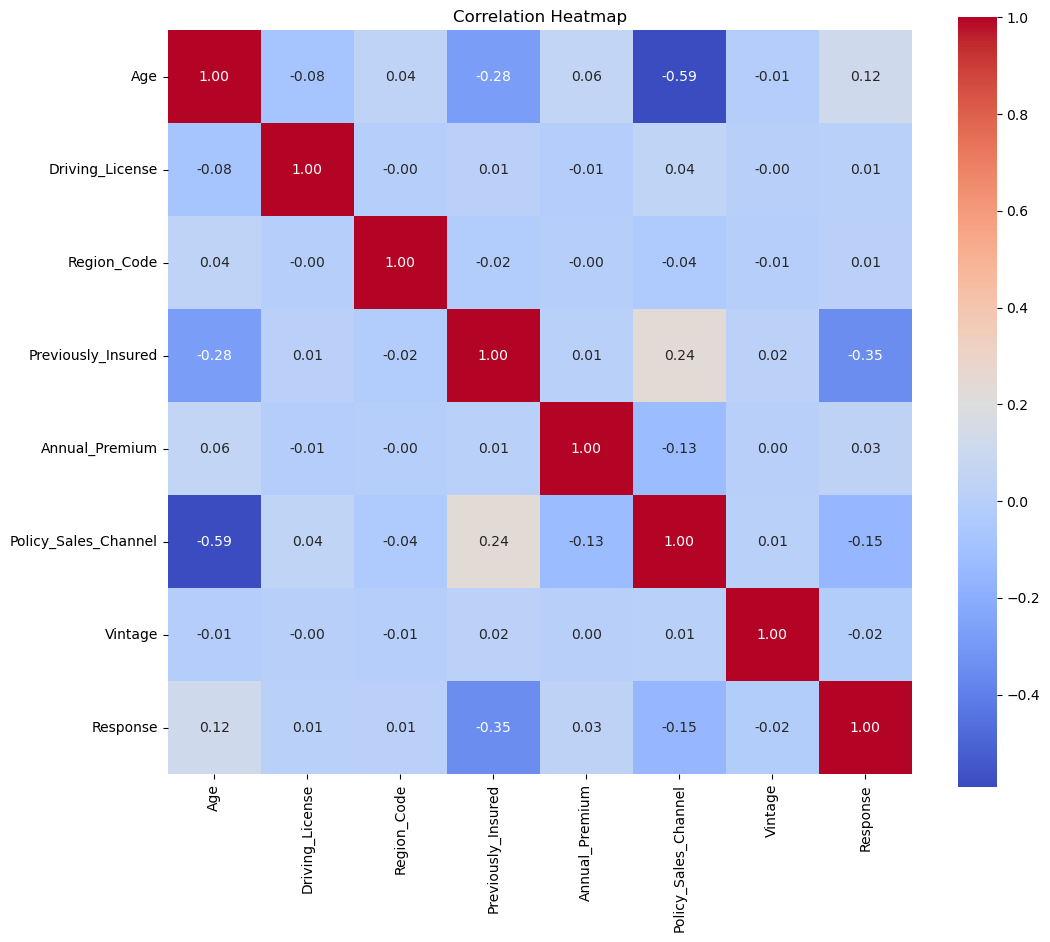

In [8]:
# Correlation matrix for numerical features
numerical_columns = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numerical_columns].corr()

# Save correlation matrix to file
correlation_matrix.to_csv(f"{logs_dir}/correlation_matrix.csv")

# Logging correlation matrix
logger.info(f"Correlation matrix:\n{correlation_matrix}")

# Correlation heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap')
heatmap.figure.savefig(f"{graphs_dir}/correlation_heatmap.png")
logger.info("Correlation heatmap saved as correlation_heatmap.png")


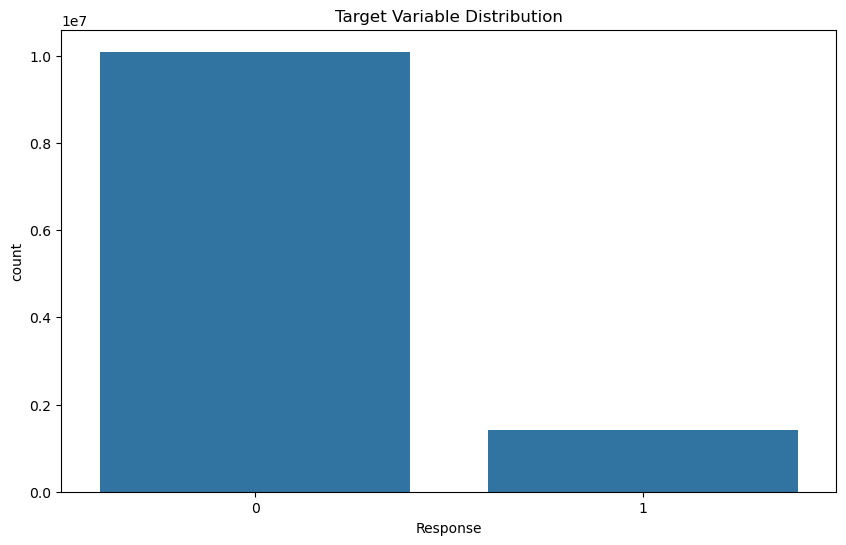

In [10]:
# Distribution of the target variable
target_distribution = train_df['Response'].value_counts()

# Logging target variable distribution
logger.info(f"Target variable distribution:\n{target_distribution}")

# Save distribution plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Response', data=train_df)
plt.title('Target Variable Distribution')
plt.savefig(f"{graphs_dir}/target_distribution.png")
logger.info("Target variable distribution plot saved as target_distribution.png")

# Efficient calculation of mean for each feature grouped by the target variable
# Using parallel processing with Dask for large datasets
import dask.dataframe as dd

# Convert pandas dataframe to dask dataframe
dask_train_df = dd.from_pandas(train_df, npartitions=10)

# Ensure only numeric columns are included in the groupby mean operation
numeric_columns = dask_train_df.select_dtypes(include=[np.number]).columns
dask_train_df_numeric = dask_train_df[numeric_columns]

# Add 'Response' column to the numeric dataframe for grouping
dask_train_df_numeric['Response'] = dask_train_df['Response']

# Group by 'Response' and calculate the mean
feature_target_relationship = dask_train_df_numeric.groupby('Response').mean().compute()

# Logging the relationship between features and target variable
logger.info(f"Relationship between features and target variable:\n{feature_target_relationship}")

# Save the relationship to a file
feature_target_relationship.to_csv(f"{logs_dir}/feature_target_relationship.csv")


In [12]:
# Calculate Z-scores for numerical columns
z_scores = np.abs(stats.zscore(train_df.select_dtypes(include=[np.number])))

# Define a threshold for identifying outliers
threshold = 3

# Identify outliers
outliers = (z_scores > threshold).sum(axis=1)
outliers_count = outliers[outliers > 0].count()

# Log the number of outliers
logger.info(f"Number of rows with outliers: {outliers_count}")


In [13]:
# Get rows with outliers
outliers_indices = np.where((z_scores > threshold).sum(axis=1) > 0)
outliers_df = train_df.iloc[outliers_indices]

# Log and save the outliers dataframe
logger.info(f"Outliers data:\n{outliers_df}")
outliers_df.to_csv(f"{logs_dir}/outliers_data.csv")


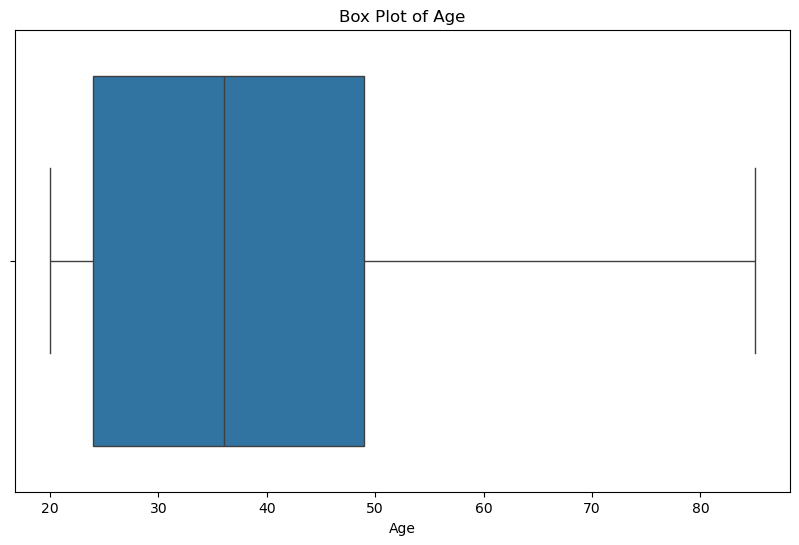

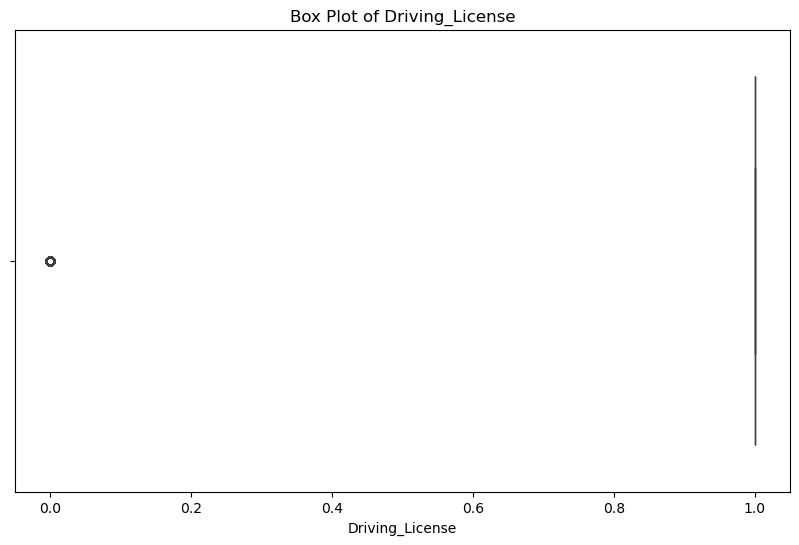

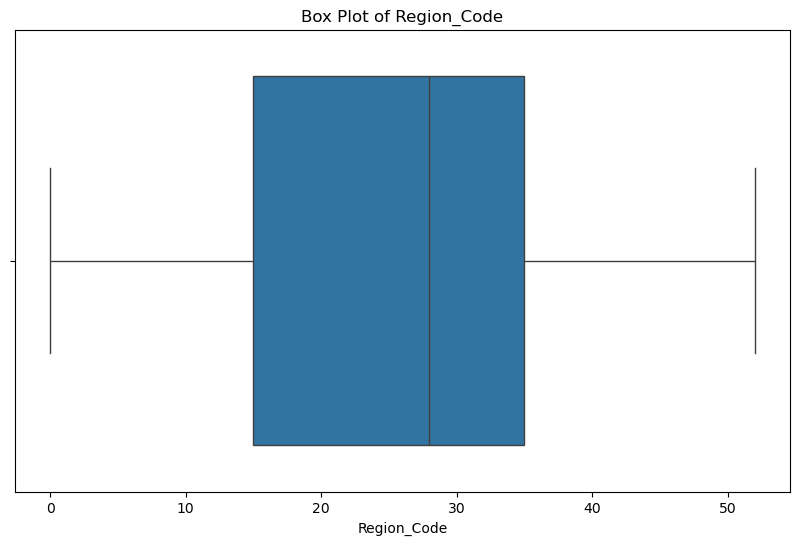

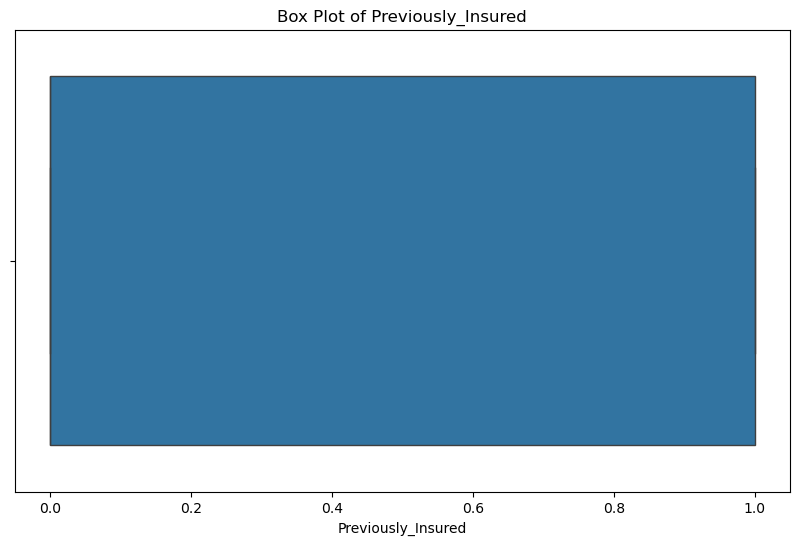

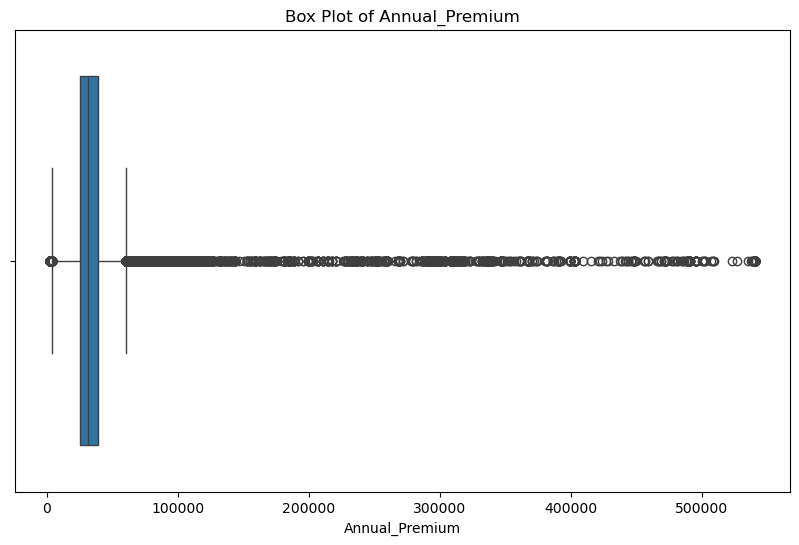

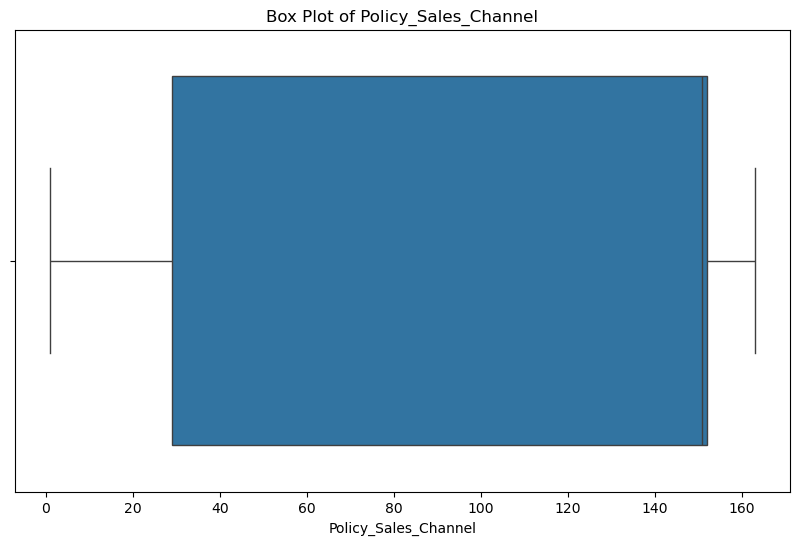

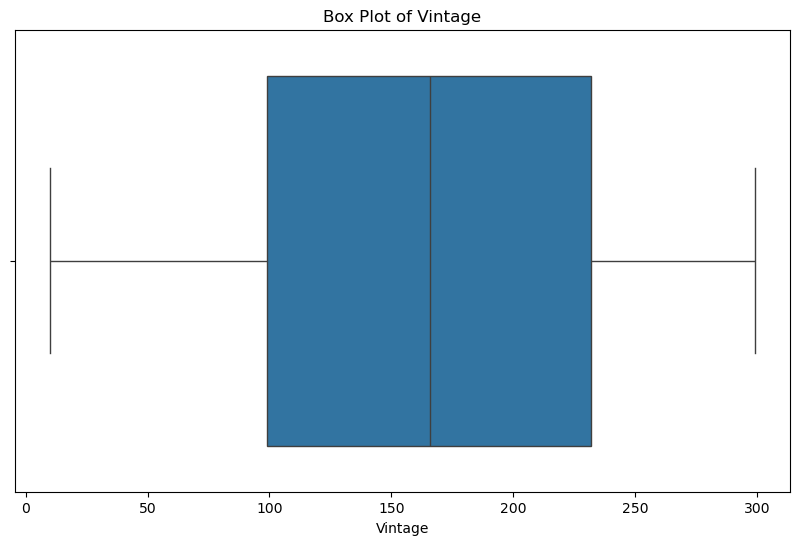

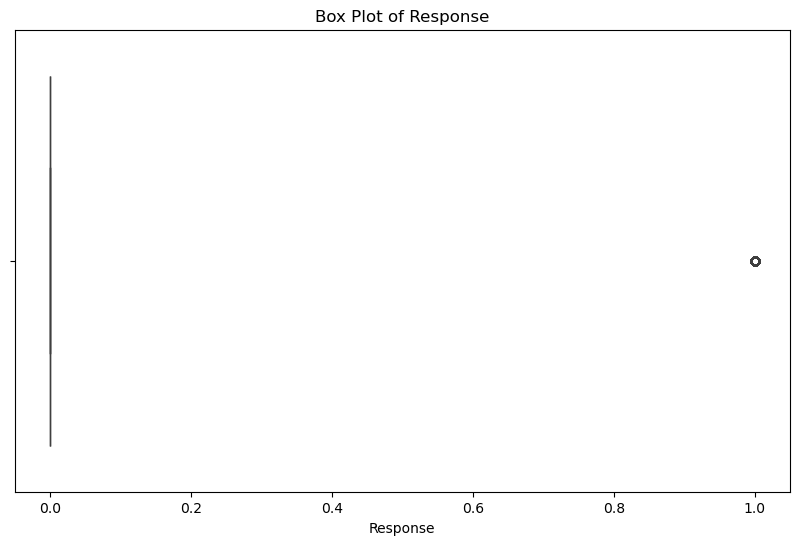

In [14]:
# Box plot for numerical features to visualize outliers
numerical_columns = train_df.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=train_df[col])
    plt.title(f'Box Plot of {col}')
    plt.savefig(f"{graphs_dir}/boxplot_{col}.png")
    logger.info(f"Box plot of {col} saved as boxplot_{col}.png")


In [15]:
# Summary statistics of outliers
outliers_summary = outliers_df.describe()

# Log and save the summary statistics of outliers
logger.info(f"Summary statistics of outliers:\n{outliers_summary}")
outliers_summary.to_csv(f"{logs_dir}/outliers_summary.csv")
